### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 5th at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import scipy.stats
from scipy.stats import norm
from scipy.stats import uniform

## (1)

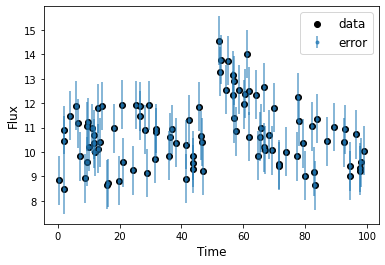

In [76]:
# (1) 
# the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties 
# on the flux. 

# Reading in time-series data and plotting it

data = np.load("../../homeworks/hw_data/hw5_data_1.npy")
time,flux,flux_sig = data[:,0],data[:,1],data[:,2]

plt.scatter(time,flux,c='k',label='data')
plt.errorbar(time, flux, yerr=flux_sig, ls=' ', marker='.',alpha=0.7,label='error')
plt.xlabel('Time',fontsize=12)
plt.ylabel('Flux',fontsize=12)
plt.legend(loc='best',fontsize=12)
plt.show()

## (2)

In [3]:
# (2)
# Making burst model function and likelihood function for this data

def burst(x,b,A,t0,alpha):
    # x is time
    y_mod = np.full(len(x),0)
    
    # y=b for t<t0
    idxes1 = np.where(np.array(x)<t0)[0]
    # y=b+Aexp[-α(t-t0)] for t>=t0
    idxes2 = np.where(np.array(x)>=t0)[0]
    
    y_mod[idxes1] = b 
    y_mod[idxes2] = b + A*np.exp(-alpha*(np.array(x)[idxes2]-t0))
        
    return np.array(y_mod)
    
def logL(theta): 
    # call burst model function
    # 'theta' is the array of parameters (b,A,t0,alpha) 
    yfit = burst(x=time,b=theta[0],A=theta[1],t0=theta[2],alpha=np.exp(theta[3]))
    return sum(scipy.stats.norm.logpdf(*args) for args in zip(flux, yfit, flux_sig))


## (3)

In [4]:
# (3) 
# Using PTMCMCSampler to perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples
# for the joint parameter space of (b,A,t0,α).

from PTMCMCSampler.PTMCMCSampler import PTSampler as ptmcmc
import scipy.stats as stats

# make function for priors (𝑏∈Uniform[0,50], 𝐴∈Uniform[0,50], 𝑡0∈Uniform[0,100], & ln𝛼∈Uniform[−5,5])
def logPrior(theta):
    
    prior_b = stats.uniform.pdf(theta[0], loc=0, scale=50)
    prior_A = stats.uniform.pdf(theta[1], loc=0, scale=50)
    prior_t0 = stats.uniform.pdf(theta[2], loc=0, scale=100)
    prior_lnalpha = stats.uniform.pdf(theta[3], loc=-5, scale=10) 
    
    return  np.log(prior_b * prior_A * prior_t0 * prior_lnalpha)

# dimension of parameter space
ndim = 4

# initial jump covariance matrix
cov = np.diag(np.ones(ndim) * 0.01**2) # this is just initializing with a value of 0.01**2

# intialize sampler
sampler = ptmcmc(ndim, logL, logPrior, cov, 
                 outDir='./my_ptmcmc_chain', resume=False) # Note to self: set 'resume' to True to resume 
                                                           # from a previous chain

# sampler for N steps
N = int(10e5) 
x0 = np.array([10., 10., 45., -1.]) # pick initial parameter values that are within the uniform prior limits 
sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50)  
#Note to self: changing SCAMweight & DEweight... would just affect acceptance rate


Optional mpi4py package is not installed.  MPI support is not available.
Finished 0.10 percent in 8.170048 s Acceptance rate = 0.921

/var/folders/8_/cx8t3z6n4c9ftpn96__x7z5c0000gq/T/ipykernel_79031/3105792955.py:16: RuntimeWarning: divide by zero encountered in log
  return  np.log(prior_b * prior_A * prior_t0 * prior_lnalpha)


Finished 1.00 percent in 77.775973 s Acceptance rate = 0.235857Adding DE jump with weight 50
Finished 99.90 percent in 8410.933388 s Acceptance rate = 0.195551
Run Complete


## (4)

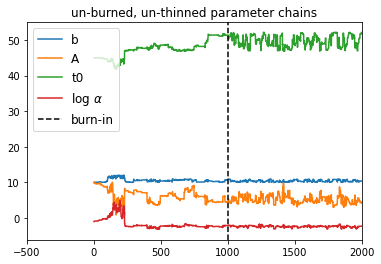

Taking every n = 12 samples based on ac length.
Burning first n = 1000 samples.


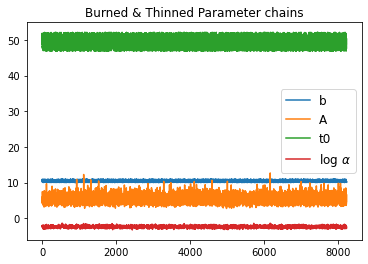

In [91]:
# (4) 
# Burning and Thinning of MCMC chain

# Load in the chain
chain = np.loadtxt('./my_ptmcmc_chain/chain_1.txt')

import acor

# perform check to burn-in the chain

# plot all parameter chains to choose an appropriate burn-in value
plt.title('un-burned, un-thinned parameter chains',fontsize=12)
plt.plot(chain[:,0],label='b');plt.plot(chain[:,1],label='A')
plt.plot(chain[:,2],label='t0');plt.plot(chain[:,3],label=r'log $\alpha$')
# 1000 seems to be a reasonable burn-in value
plt.axvline(1000,ls='--',c='k',label='burn-in')
plt.xlim(-500,2000)
plt.legend(loc='upper left',fontsize=12)
plt.show()

brn = 1000 # Note: since many (10^5) samples were used to run the MCMC, burning 1/4th of the chain 
           # 'brn=int(len(chain[:,0])*1/4)' would've also been okay
# thin the chain by selecting only points every auto-correlation length
thin = int(acor.acor(chain[:,0])[0])

print('Taking every n = ' + str(thin) + ' samples based on ac length.')
print('Burning first n = ' + str(brn) + ' samples.')

b_downsampled = chain[brn::thin,0] 
A_downsampled = chain[brn::thin,1]
t0_downsampled = chain[brn::thin,2]
alpha_downsampled = chain[brn::thin,3]

plt.title('Burned & Thinned Parameter chains',fontsize=12)
plt.plot(b_downsampled,label='b')
plt.plot(A_downsampled,label='A')
plt.plot(t0_downsampled,label='t0')
plt.plot(alpha_downsampled,label=r'log $\alpha$')
plt.legend(loc='best',fontsize=12)
plt.show()


## (5)

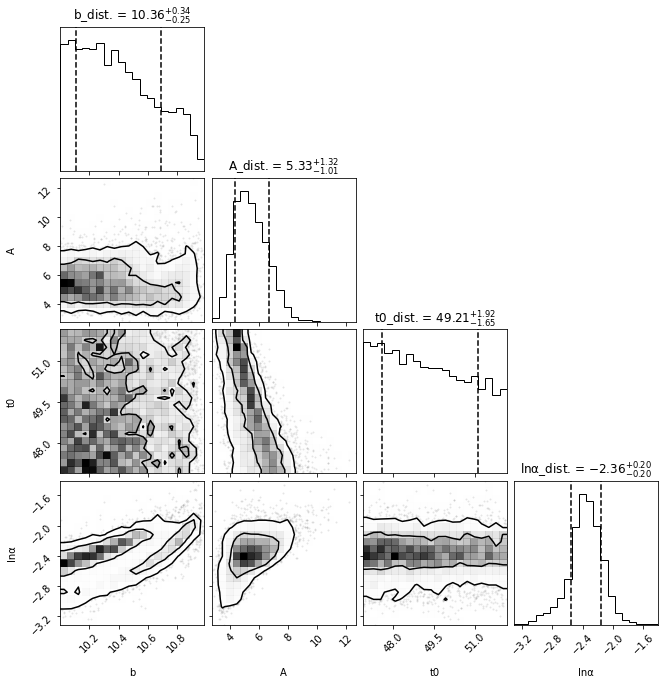

In [92]:
# (5) 
# corner plot of the 4-D parameter space, with labels, [68,95]% credible levels and quantiles, and titles.

import corner

combined = np.array([b_downsampled,A_downsampled,t0_downsampled,alpha_downsampled])
_=corner.corner(combined.T, quantiles=(0.16, 0.84), levels=(0.68,0.95), labels=['b','A','t0','lnα']
                    ,titles=['b_dist.','A_dist.','t0_dist.','lnα_dist.'],show_titles=True)

## (6)

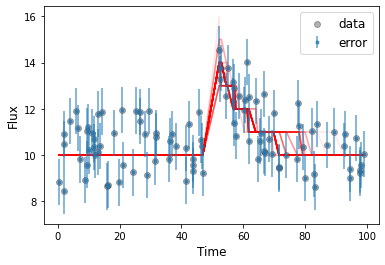

In [95]:
# (6) 
# Choose  100  samples randomly from the burned, thinned chains and plot the 100 corresponding burst 
# time-series on a figure along with the original data. These 100 burst curves are showing the posterior 
# spread of model solutions that are consistent with the data.

import random
from random import choices

idxs = choices(np.arange(0,len(b_downsampled),1),k=100) 

for i in idxs:
    
    b_random = b_downsampled[i] 
    A_random = A_downsampled[i] 
    t0_random = t0_downsampled[i] 
    alpha_random = alpha_downsampled[i] 
    burst_flux = burst(time,b_random,A_random,t0_random,np.exp(alpha_random))
    plt.plot(time,burst_flux,c='red',alpha=0.1)

plt.scatter(time,flux,c='k',label='data',alpha=0.3)
plt.errorbar(time, flux, yerr=flux_sig, ls=' ', marker='.',alpha=0.7,label='error')
plt.xlabel('Time',fontsize=12)
plt.ylabel('Flux',fontsize=12)
plt.legend(fontsize=12)
plt.show()

### I'm not sure why the the model isn't as smooth after the burst (looks jagged after Time~60). I've performed a check at the end of problem (7) to see if this is due to some mistake in how I did the parameter calculations using PTMCMCSampler.

## (7)

In [38]:
# (7) Using gaussian model to explain data, and then using nested sampling package 'dynesty' to compute Bayesian
# evidence for this gaussian model. 
import dynesty 

# Define the dimensionality of our problem.
ndim = 4

# make gaussian model function for data this time 
def gauss(x,b,A,t0,sig_w):
    # x is time
    # y=b+Aexp[-(t-t0)^2 / 2σ_w^2]
    y_mod = b + A*np.exp(-((np.array(x)-t0)**2) / (2*sig_w**2))
        
    return np.array(y_mod)

# make likelihood function
def loglike(theta): 
    # call burst model function
    # 'theta' is the array of parameters (b,A,t0,sig_w) 
    yfit = gauss(x=time,b=theta[0],A=theta[1],t0=theta[2],sig_w=np.exp(theta[3]))
    return sum(scipy.stats.norm.logpdf(*args) for args in zip(flux, yfit, flux_sig))

def ptform(u):
    params = u.copy()

    params[0] = u[0]*50.
    params[1] = u[1]*50.
    params[2] = u[2]*100.
    params[3] = 2. * (2. * u[3] - 1.)

    return  params

In [39]:
# "Static" nested sampling for gaussian model.
sampler = dynesty.NestedSampler(loglike, ptform, ndim)
sampler.run_nested()
sresults = sampler.results

iter: 7958 | +500 | bound: 33 | nc: 1 | ncall: 41911 | eff(%): 20.181 | loglstar:   -inf < -144.334 <    inf | logz: -159.522 +/-  0.245 | dlogz:  0.001 >  0.509                                     

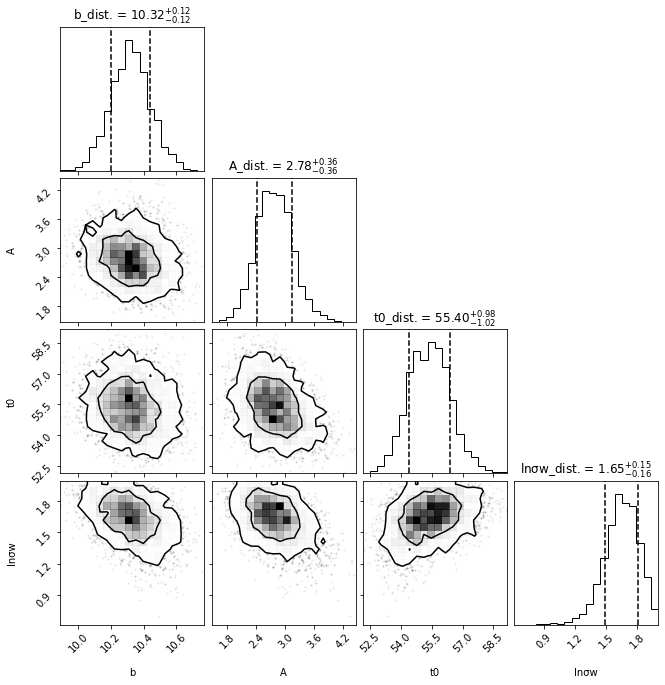

In [225]:
# Make Gaussian model corner plot

from dynesty import utils as dyfunc

# Extract sampling results.
samples = sresults.samples  # samples
weights = np.exp(sresults.logwt - sresults.logz[-1])  # normalized weights
# Resample weighted samples.
samples_equal = dyfunc.resample_equal(samples, weights)


_=corner.corner(samples_equal, quantiles=(0.16, 0.84), levels=(0.68,0.95), labels=['b','A','t0','lnσw']
                    ,titles=['b_dist.','A_dist.','t0_dist.','lnσw_dist.'],show_titles=True)

In [100]:
# Doing the same thing but for the burst model. 
# Need to make sure prior function is in the appropriate format for dynesty!

def ptformburst(u):
    params = u.copy()

    params[0] = u[0]*50.
    params[1] = u[1]*50.
    params[2] = u[2]*100.
    params[3] = 5. * (2. * u[3] - 1.)
    
    return params

# "Static" nested sampling for burst model.
sampler_burst = dynesty.NestedSampler(logL, ptformburst, ndim)
sampler_burst.run_nested()
sresults_burst = sampler_burst.results

iter: 7750 | +500 | bound: 99 | nc: 1 | ncall: 97060 | eff(%):  8.500 | loglstar:   -inf < -140.646 <    inf | logz: -155.472 +/-  0.250 | dlogz:  0.001 >  0.509                                     

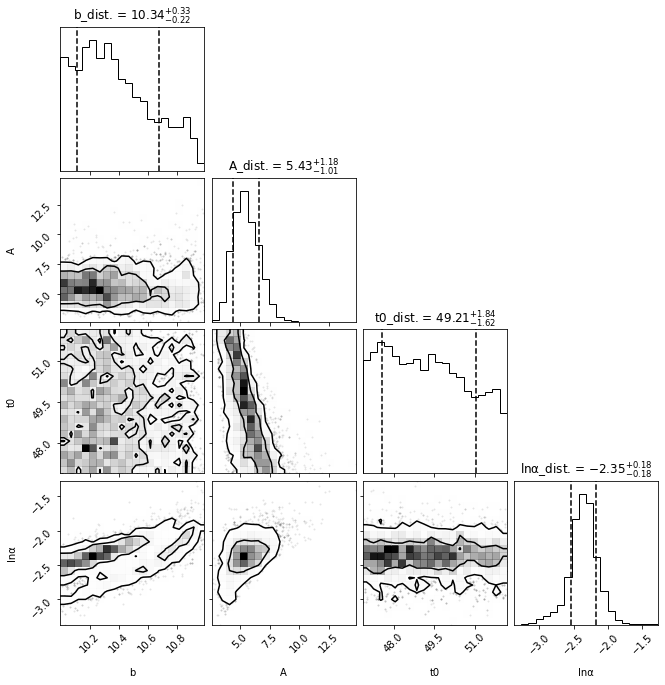

In [256]:
# Make Burst model corner plot

# Extract sampling results.
samples_burst = sresults_burst.samples  # samples
weights_burst = np.exp(sresults_burst.logwt - sresults_burst.logz[-1])  # normalized weights
# Resample weighted samples.
samples_equal_burst = dyfunc.resample_equal(samples_burst, weights_burst)


_=corner.corner(samples_equal_burst, quantiles=(0.16, 0.84), levels=(0.68,0.95), labels=['b','A','t0','lnα']
                    ,titles=['b_dist.','A_dist.','t0_dist.','lnα_dist.'],show_titles=True)

### This corner plot is equivalent to the burst model corner plot in problem (5)!

In [259]:
# Compute the Bayes factor, and state which model is the favored description of the data. 
# But first, finding the posterior and taking the sum to get Bayesian Evidence.

# CALCULATING THE POSTERIOR FOR THE BURST MODEL

# Choose 100  samples randomly from the burned, thinned chains
idxs1 = choices(np.arange(0,len(samples_equal_burst[:,0]),1),k=100)
thet1 = np.array([samples_equal_burst[:,0][idxs],samples_equal_burst[:,1][idxs],
                 samples_equal_burst[:,2][idxs],samples_equal_burst[:,3][idxs]])

prior_burst = []
for i in range(len(thet1[0])):
    th = np.array([thet1[0][i],thet1[1][i],thet1[2][i],thet1[3][i]])
    lnL = logL(th)
    lnP = logPrior(th)
    pri = lnL+lnP # sum because we're in log space 
    prior_burst.append(pri)
    
# Find Bayesian evidence
prior_burst = np.sum(prior_burst)
print(prior_burst)

-15830.591249608264


In [260]:
# CALCULATING THE POSTERIOR FOR THE GAUSSIAN MODEL

# First, make a prior function that's different from the dynesty compatible format
def lnPriorGauss(theta):
    
    prior_b = stats.uniform.pdf(theta[0], loc=0, scale=50)
    prior_A = stats.uniform.pdf(theta[1], loc=0, scale=50)
    prior_t0 = stats.uniform.pdf(theta[2], loc=0, scale=100)
    prior_lnsigw = stats.uniform.pdf(theta[3], loc=-2, scale=4) 

    return  np.log(prior_b * prior_A * prior_t0 * prior_lnsigw)


idxs2 = choices(np.arange(0,len(samples_equal[:,0]),1),k=100)
thet2 = np.array([samples_equal[:,0][idxs1],samples_equal[:,1][idxs1],
                 samples_equal[:,2][idxs1],samples_equal[:,3][idxs1]])

prior_gauss = []
for i in range(len(thet2[0])):
#     print(i)
    th_gauss = np.array([thet2[0][i],thet2[1][i],thet2[2][i],thet2[3][i]])
    lnL_gauss = loglike(th_gauss)
    lnP_gauss = lnPriorGauss(th_gauss)
    pri_gauss = lnL_gauss+lnP_gauss # sum because we're in log space
    prior_gauss.append(pri_gauss)

# Find Bayesian evidence
prior_gauss = np.sum(prior_gauss)
print(prior_gauss)

-16012.691857940052


In [263]:
# Calculating Bayes factor to find which model is the favored description of the data

bfactor = prior_gauss/prior_burst
print('\nBayes factor (B21) = ',bfactor,
      '\n\nIt looks like both models describe the data really well (Bayes factor is ~1), but the Gaussian model',
      '(model 2) seems to be very slightly more favored than the Burst model (model 1).')


Bayes factor (B21) =  1.011503083205202 

It looks like both models describe the data really well (Bayes factor is ~1), but the Gaussian model (model 2) seems to be slightly more favored than the Burst model (model 1).


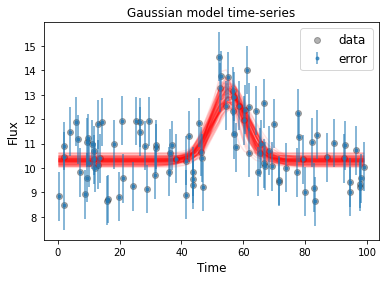

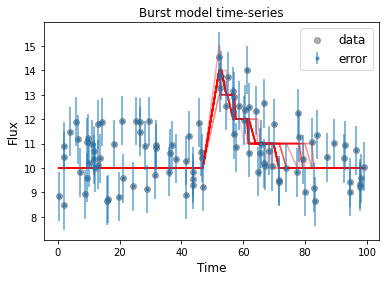

In [266]:
# SANITY CHECK : choose 100 samples randomly and plot those 100 gaussian time-series along with the original data. 

idxs = choices(np.arange(0,len(b_downsampled),1),k=100) 
idxs1 = choices(np.arange(0,len(samples_equal[:,0]),1),k=100)

for i in idxs1:
    
    brandom = samples_equal[:,0][i] 
    Arandom = samples_equal[:,1][i] 
    t0random = samples_equal[:,2][i] 
    sigrandom = samples_equal[:,3][i] 
    gaussflux = gauss(time,brandom,Arandom,t0random,np.exp(sigrandom))
    plt.plot(time,gaussflux,c='red',alpha=0.1)
    
plt.title('Gaussian model time-series',fontsize=12)
plt.scatter(time,flux,c='k',label='data',alpha=0.3)
plt.errorbar(time, flux, yerr=flux_sig, ls=' ', marker='.',alpha=0.7,label='error')
plt.xlabel('Time',fontsize=12)
plt.ylabel('Flux',fontsize=12)
plt.legend(fontsize=12)
plt.show()

# Do the same thing for the burst model, but use the parameter chains from the nested sampling (unlike in problem 6)
idx = choices(np.arange(0,len(samples_equal_burst[:,0]),1),k=100)

for i in idx:
    
    brandom = samples_equal_burst[:,0][i] 
    Arandom = samples_equal_burst[:,1][i] 
    t0random = samples_equal_burst[:,2][i] 
    alpharandom = samples_equal_burst[:,3][i] 
    burstflux = burst(time,brandom,Arandom,t0random,np.exp(alpharandom))
    plt.plot(time,burstflux,c='red',alpha=0.1)

plt.title('Burst model time-series',fontsize=12)
plt.scatter(time,flux,c='k',label='data',alpha=0.3)
plt.errorbar(time, flux, yerr=flux_sig, ls=' ', marker='.',alpha=0.7,label='error')
plt.xlabel('Time',fontsize=12)
plt.ylabel('Flux',fontsize=12)
plt.legend(fontsize=12)
plt.show()

### First of all, the burst model plot plotted using parameters from the nested sampling looks exactly like the plot from problem 6 (plotted using the parameters from PTMCMCSampler). This convinces me a bit more that maybe I did nothing wrong to cause the jaggedness of the burst model plot.

### And based on the appearance of the data alone, I would've expected the burst model to be the slightly more favored description of the data. I'm thinking that's not the case probably due to the zigzag-ing seen in the burst model plot--I'm still not sure why that's happening.

### Overall, I would say that the Gaussian model is a believable description of the data. But based on the appearance of the data, I'm not entirely convinced that it's necessarily a 'better model' than the Burst model. 